In [22]:
%pylab inline
del all, any

Populating the interactive namespace from numpy and matplotlib


/home/moe/.virtualenvs/sci3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [71]:
import rtree
from collections import namedtuple
from enum import Enum
from typing import Union, List

In [99]:
Point = namedtuple('Point', ['x', 'y'])
ParametricLine = namedtuple('ParametricLine', ['p', 'u'])
Line = namedtuple('Line', ['homogenous', 'parametric', 'p1', 'p2'])

def pt(xy):
    x, y = xy
    return Point(x=x, y=y)

class DenormalizedIntersection(Enum):
    nowhere = 0
    everywhere = 1


IntersectionPoint = namedtuple('IntersectionPoint', ['location', 'on_l1', 'on_l2', 's1', 's2'])
Intersection = Union[IntersectionPoint, DenormalizedIntersection]


def homogenous_form(p1, p2) -> np.ndarray:
    return np.cross([p1.x, p1.y, 1.0], [p2.x, p2.y, 1.0])

def parametric_form(p1, p2) -> ParametricLine:
    f = np.asfarray
    # Vektor
    u = f([p2.x - p1.x, p2.y - p1.y])
    # Fußpunkt
    p = f([p1.x, p1.y])
    return ParametricLine(p=p, u=u)


def line_from_endpoints(p1, p2) -> Line:
    return Line(homogenous=homogenous_form(p1, p2),
                parametric=parametric_form(p1, p2),
                p1=p1, p2=p2)


def parametric_eval(pf, s):
    return pf.p + (s * pf.u)


def parametric_solve(pf, p: Point) -> (float, float):
    a = np.matrix(pf.u).T
    b = np.matrix([p.x - pf.p[0], p.y - pf.p[1]]).T
    x, residuals, _, _ = np.linalg.lstsq(a, b, rcond=None)
    return x[0, 0], residuals[0, 0]


def intersection(l1: Line, l2: Line) -> Intersection:
    ix = np.cross(l1.homogenous, l2.homogenous)
    if np.allclose(ix, 0):
        return DenormalizedIntersection.everywhere
    if np.allclose(ix[2], 0):
        return DenormalizedIntersection.nowhere
    # Now check whether point lies on both lines
    ixp = Point(ix[0] / ix[2], ix[1] / ix[2])
    s1, r1 = parametric_solve(l1.parametric, ixp)
    s2, r2 = parametric_solve(l2.parametric, ixp)
    return IntersectionPoint(location=ixp, on_l1=0 <= s1 <= 1, on_l2=0 <= s2 <= 1, s1=s1, s2=s2)

In [89]:
def display(paths):
    figure()
    axis('equal')
    for path in paths:
        xx, yy = np.asarray(path).T
        plot(xx, yy, '-')

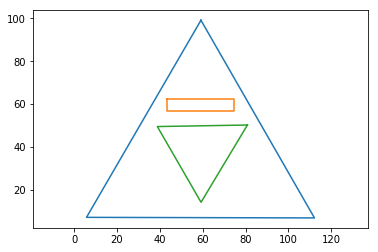

In [90]:
paths = [
    [(59.1836, 99.1797), (5.73438, 7.13281), (112.176, 6.87109), (59.1836, 99.1797)],
    [(43.2422, 62.5703), (74.668, 62.5703), (74.668, 56.5703), (43.2422, 56.5703), (43.2422, 62.5703)],
    [(80.8789, 50.2539), (59.2227, 14.1797), (38.8125, 49.5352), (80.8789, 50.2539)],
]

display(paths)

In [113]:
def even_odd_rule_inside(num_crossings):
    return (num_crossings%2)==1

def outside_bbox_paths(paths, x, y):
    def outside(path, x, y):
        xx, yy = np.asarray(path).T
        x_min, x_max = xx.min(), xx.max()
        y_min, y_max = yy.min(), yy.max()
        outside_x = (x < x_min) or (x > x_max)
        outside_y = (y < y_min) or (y > y_max)
        return outside_x or outside_y
    return all(outside(path, x, y) for path in paths)

def outside_bbox(index, x, y):
    x_min, y_min, x_max, y_max = index.bounds
    outside_x = (x < x_min) or (x > x_max)
    outside_y = (y < y_min) or (y > y_max)
    return outside_x or outside_y
    
    
def ensure_closed(path):
    xx, yy = np.asarray(path).T
    closed = (xx[0]==xx[-1]) and (yy[0]==yy[-1])
    if closed:
        return path
    else:
        xx_out = np.hstack((xx_out, xx[0]))
        yy_out = np.hstack((yy_out, yy[0]))
        return np.vstack((xx_out,yy_out)).T
        
    
def build_index(paths):
    def gen_entries():
        counter = 0
        for path in paths:
            closed_path = ensure_closed(path)
            for p,q in zip(closed_path[:-1], closed_path[1:]):
                px, py = p
                qx, qy = q
                bounds = min(px,qx), min(py,qy), max(px,qx), max(py,qy)
                obj = p,q
                entry = counter, bounds, obj
                yield entry
                counter += 1
    index = rtree.Rtree(gen_entries())
    return index

def dilate_bounds(interleaved_bounds, amount):
    min_x, min_y, max_x, max_y = interleaved_bounds
    return [min_x-amount, min_y-amount, max_x+amount, max_y+amount]

def query(index, min_x, y, bbox):
    max_x = bbox[2]
    min_y = max_y = y
    lines = [ line_from_endpoints(pt(item.object[0]), pt(item.object[1])) for item in index.intersection((min_x, min_y, max_x, max_y), objects=True)]
    return lines

def make_sweeping_ray(min_x, y, bbox):
    max_x = bbox[2]
    return line_from_endpoints(Point(x=min_x,y=y), Point(x=max_x,y=y))

def preprocess(paths):
    index = build_index(paths)
    return index

def pt_in_poly(index, x, y):
    if outside_bbox(index, x,y):
        return False
    eps=1.0
    bbox = dilate_bounds(index.bounds, eps)
    intersecting_segments = query(index, x, y, bbox)
    sweeping_ray = make_sweeping_ray(x,y, bbox)
    intersections = [ intersection(s, sweeping_ray) for s in intersecting_segments ]
    crossings = set( ix.s2 for ix in intersections if ix.on_l2 )
    return even_odd_rule_inside(len(crossings))

index = preprocess(paths)
assert(pt_in_poly(index, 80, 20)==True)
assert(pt_in_poly(index, 60, 40)==False)
assert(pt_in_poly(index, -100, 40)==False)

In [108]:
timeit preprocess(paths)

873 µs ± 38.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [114]:
timeit pt_in_poly(index, -100, 10)

66 µs ± 2.16 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [115]:
%load_ext line_profiler

In [119]:
%lprun -f parametric_solve pt_in_poly(index,10,10)